## Case Study #3 - Foodie-Fi

#### Problem Statement
Subscription based businesses are super popular and Danny realised that there was a large gap in the market - he wanted to create a new streaming service that only had food related content - something like Netflix but with only cooking shows!

Danny finds a few smart friends to launch his new startup Foodie-Fi in 2020 and started selling monthly and annual subscriptions, giving their customers unlimited on-demand access to exclusive food videos from around the world!

Danny created Foodie-Fi with a data driven mindset and wanted to ensure all future investment decisions and new features were decided using data. This case study focuses on using subscription style digital data to answer important business questions.

Danny has shared the data design for Foodie-Fi and also short descriptions on each of the database tables - our case study focuses on only 2 tables but there will be a challenge to create a new table for the Foodie-Fi team.

#### Entity Relationship Diagram

![week3.png](week3.png)

Import modules

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
pd.set_option('display.max_columns', None)

Initialize SQL

In [2]:
conn = sql.connect("week3.db")
cursor = conn.cursor() 
if os.stat("week3.db").st_size == 0:
    with open('week3-sql.txt','r') as file:
        script = file.read()
        script = script.replace('\n', ' ')
    cursor.executescript(script)

Verify tables

In [3]:
query = """SELECT name FROM sqlite_master WHERE type='table';"""
cursor.execute(query)
tables = [table[0] for table in cursor.fetchall()]
tables
print(f'The tables in the database are: {', '.join(tables)}')

The tables in the database are: plans, subscriptions


Fetch table information

In [4]:
for table in tables:
    print("=================================")
    print(f'Table [{table}]')
    df = pd.read_sql_query(f'SELECT * FROM {table}', conn)
    print(f'Dimensions: {df.shape[0]} rows x {df.shape[1]} columns\n')
    print(df.head())
    info_df = pd.DataFrame.from_dict({'Datatypes':df.dtypes, 'NULL count':df.isna().sum()})
    print()
    print(info_df)
    print()

Table [plans]
Dimensions: 5 rows x 3 columns

   plan_id      plan_name  price
0        0          trial    0.0
1        1  basic monthly    9.9
2        2    pro monthly   19.9
3        3     pro annual  199.0
4        4          churn    NaN

          Datatypes  NULL count
plan_id       int64           0
plan_name    object           0
price       float64           1

Table [subscriptions]
Dimensions: 2650 rows x 3 columns

   customer_id  plan_id  start_date
0            1        0  2020-08-01
1            1        1  2020-08-08
2            2        0  2020-09-20
3            2        3  2020-09-27
4            3        0  2020-01-13

            Datatypes  NULL count
customer_id     int64           0
plan_id         int64           0
start_date     object           0



In [5]:
def query(stmt: str):
    """Executes a given SQL statement and returns a Pandas DataFrame given the results.
    
    Parameters
    ----------
    stmt: str
        The SQL statement to be executed
    """
    global conn
    result = pd.read_sql_query(stmt, conn)
    return result

## Case Study Questions

This case study is split into an initial data understanding question before diving straight into data analysis questions before finishing with 1 single extension challenge.

**A. Customer Journey**

Q1: Based off the 8 sample customers provided in the sample from the subscriptions table, write a brief description about each customer’s onboarding journey.

Try to keep it as short as possible - you may also want to run some sort of join to make your explanations a bit easier!

- The IDs of the sample customers were: 1, 2, 11, 13, 15, 16, 18, 19

In [6]:
# Create a table where each row is a customer and the columns represent the start dates of their plans
query('''
    WITH customers (customer_id) as (VALUES (1),(2),(11),(13),(15),(16),(18),(19)),
    
    p0_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 0
        AND customer_id IN customers
    ),
    p1_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 1
        AND customer_id IN customers
    ),
    p2_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 2
        AND customer_id IN customers
    ),
    p3_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 3
        AND customer_id IN customers
    ),
    p4_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 4
        AND customer_id IN customers
    )
      
    SELECT customers.customer_id,
        p0.start_date as trial_date,
        p1.start_date as basic_monthly_date,
        p2.start_date as pro_monthly_date,
        p3.start_date as pro_annual_date,
        p4.start_date as churn_date
    FROM customers
        LEFT JOIN p0_dates p0 USING (customer_id)
        LEFT JOIN p1_dates p1 USING (customer_id)
        LEFT JOIN p2_dates p2 USING (customer_id)
        LEFT JOIN p3_dates p3 USING (customer_id)
        LEFT JOIN p4_dates p4 USING (customer_id)
''')

,customer_id,trial_date,basic_monthly_date,pro_monthly_date,pro_annual_date,churn_date
0,1,2020-08-01,2020-08-08,None,None,None
1,2,2020-09-20,None,None,2020-09-27,None
2,11,2020-11-19,None,None,None,2020-11-26
3,13,2020-12-15,2020-12-22,2021-03-29,None,None
4,15,2020-03-17,None,2020-03-24,None,2020-04-29
5,16,2020-05-31,2020-06-07,None,2020-10-21,None
6,18,2020-07-06,None,2020-07-13,None,None
7,19,2020-06-22,None,2020-06-29,2020-08-29,None


- Customer 1 started his free trial on Aug 1, 2020 and subscribed to the basic monthly plan 7 days after until present.
- Customer 2 started his free trial on Sep 20, 2020 and subscribed to the pro annual plan 7 days after until present.
- Customer 15 started his free trial on Mar 17, 2020 and subscribed to the pro monthly plan 7 days after, but churned on Apr 29, 2020.

**B. Data Analysis Questions**

Q2: How many customers has Foodie-Fi ever had?

In [7]:
query('''
    SELECT COUNT(DISTINCT customer_id) AS num_customers
    FROM subscriptions;
''')

,num_customers
0,1000


Q3: What is the monthly distribution of trial plan start_date values for our dataset - use the start of the month as the group by value

In [8]:
q3_df = query('''
    SELECT
        strftime('%m',start_date) AS month_date, -- Cast start_date as month in numerical format
        COUNT(s.customer_id) AS trial_plan_subscriptions
    FROM subscriptions AS s
        JOIN plans p
        ON s.plan_id = p.plan_id
    WHERE s.plan_id = 0 -- Trial plan ID is 0
    GROUP BY month_date
    ORDER BY month_date;
''')
q3_df

,month_date,trial_plan_subscriptions
0,01,88
1,02,68
2,03,94
3,04,81
4,05,88
5,06,79
6,07,89
7,08,88
8,09,87
9,10,79


<Axes: xlabel='month_date', ylabel='trial_plan_subscriptions'>

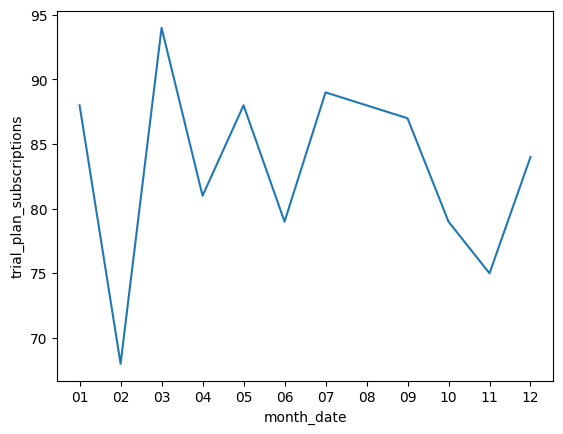

In [12]:
sns.lineplot(data=q3_df,x='month_date',y='trial_plan_subscriptions')

Q4: What is the customer count and percentage of customers who have churned rounded to 1 decimal place?

In [30]:
query('''
    WITH num_customers AS(
        SELECT COUNT(DISTINCT customer_id) AS num_customers
        FROM subscriptions 
    )
    SELECT
        COUNT(DISTINCT customer_id) AS churned_count,
        ROUND(COUNT(DISTINCT customer_id) / CAST(num_customers AS FLOAT) * 100,1) || ' %' AS percentage
        FROM subscriptions, num_customers
        WHERE plan_id = 4
''')

,churned_count,percentage
0,307,30.7 %


Bonus: Visualizing the distribution of number of days taken for customers to churn:

In [56]:
q4b_df = query('''
    WITH p0_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 0
    ),
    p4_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 4
    )
    SELECT
        p4.customer_id,
        julianday(p4.start_date) - julianday(p0.start_date) AS 'length (days)'
    FROM
        p4_dates p4
        INNER JOIN p0_dates p0 ON p4.customer_id = p0.customer_id
''')
q4b_df

,customer_id,length (days)
0,4,95.0
1,6,65.0
2,11,7.0
3,15,43.0
4,21,236.0
...,...,...
302,993,7.0
303,996,26.0
304,997,110.0
305,999,39.0


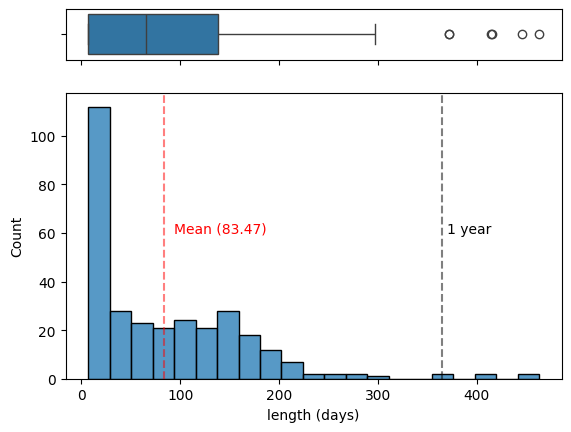

In [59]:
mean_length = q4b_df['length (days)'].mean()
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(q4b_df["length (days)"], orient="h", ax=ax_box)
sns.histplot(data=q4b_df, x="length (days)", bins=int(np.sqrt(q4b_df['length (days)'].max())), ax=ax_hist)
plt.axvline(x = 365, color = 'black', alpha=0.5, linestyle='dashed')
plt.text(370,60, '1 year', color='black')
plt.axvline(x = mean_length, color='red', alpha=0.5, linestyle='dashed')
plt.text(mean_length+10, 60, f'Mean ({mean_length:.2f})', color='red')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

If excluding customers churning right after their initial free trial:

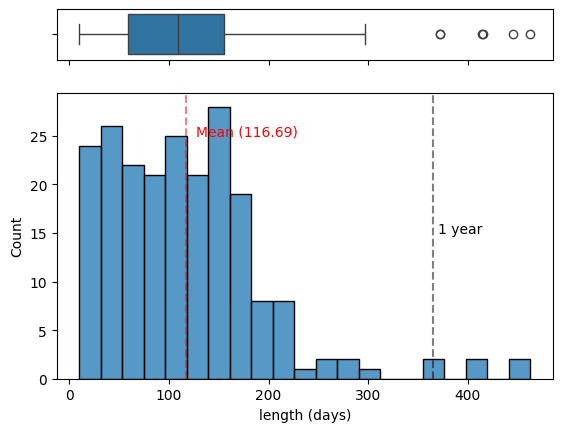

In [61]:
q4b_df_2 = q4b_df[q4b_df['length (days)'] > 8]
mean_length = q4b_df_2['length (days)'].mean()
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(q4b_df_2["length (days)"], orient="h", ax=ax_box)
sns.histplot(data=q4b_df_2, x="length (days)", bins=int(np.sqrt(q4b_df_2['length (days)'].max())), ax=ax_hist)
plt.axvline(x = 365, color = 'black', alpha=0.5, linestyle='dashed')
plt.text(370,15, '1 year', color='black')
plt.axvline(x = mean_length, color='red', alpha=0.5, linestyle='dashed')
plt.text(mean_length+10, 25, f'Mean ({mean_length:.2f})', color='red')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

Q5: How many customers have churned straight after their initial free trial - what percentage is this rounded to the nearest whole number?

In [72]:
query('''
    WITH num_customers AS(
        SELECT COUNT(DISTINCT customer_id) AS num_customers
        FROM subscriptions 
    ),
    p0_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 0
    ),
    p4_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 4
    )   
    SELECT
        COUNT(DISTINCT p4.customer_id) AS churned_count,
        ROUND(COUNT(DISTINCT p4.customer_id) / CAST(num_customers AS FLOAT) * 100,0) || ' %' AS percentage
        FROM num_customers, p4_dates p4
            INNER JOIN p0_dates p0 ON p4.customer_id = p0.customer_id
        WHERE
            julianday(p4.start_date) - julianday(p0.start_date) <= 7 --Churned straight after initial free trial
''')

,churned_count,percentage
0,92,9.0 %


Q6: What is the number and percentage of customer plans after their initial free trial?

In [76]:
# Use LEAD() to get the next plan partitioned by customer id after their initial free trial
q6_df = query('''
    WITH next_plans AS (
        SELECT 
            customer_id, 
            plan_id, 
            LEAD(plan_id) OVER(
                PARTITION BY customer_id 
                ORDER BY plan_id) as next_plan_id
        FROM subscriptions
    )

    SELECT 
        next_plan_id AS plan_id, 
        COUNT(customer_id) AS converted_customers,
        ROUND(100 * 
            CAST(COUNT(customer_id) AS FLOAT) 
            / (SELECT COUNT(DISTINCT customer_id) 
            FROM subscriptions)
        ,1) || ' %' AS conversion_percentage
    FROM next_plans
    WHERE plan_id = 0
    GROUP BY next_plan_id
    ORDER BY next_plan_id;
''')
q6_df

,plan_id,converted_customers,conversion_percentage
0,1,546,54.6 %
1,2,325,32.5 %
2,3,37,3.7 %
3,4,92,9.2 %


<Axes: xlabel='converted_customers', ylabel='plan_id'>

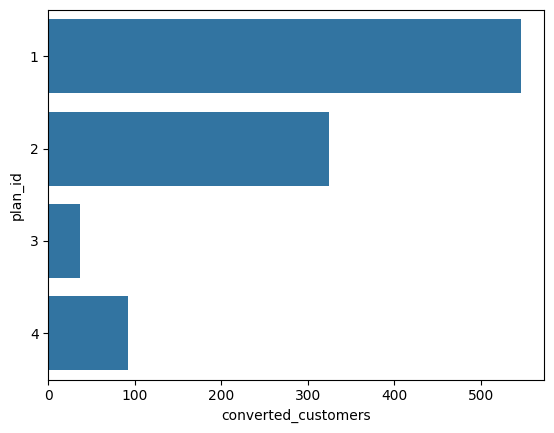

In [81]:
sns.barplot(data=q6_df, y='plan_id', x='converted_customers', orient='h')

Q7: What is the customer count and percentage breakdown of all 5 plan_name values at 2020-12-31?

In [90]:
# Same approach as Q6, but set a filter to remove rows beyond 2020-12-31
query('''
    WITH next_dates AS (
        SELECT
            customer_id,
            plan_id,
            start_date,
            LEAD(start_date) OVER (
                PARTITION BY customer_id
                ORDER BY start_date
                ) AS next_date
        FROM subscriptions
        WHERE start_date <= '2020-12-31'
    ),
    num_customers AS (
        SELECT COUNT(DISTINCT customer_id) AS num_customers
        FROM subscriptions
        WHERE start_date <= '2020-12-31'
    )  

    SELECT
        plan_id, 
        COUNT(DISTINCT customer_id) AS customers,
        ROUND(100.0 * 
            COUNT(DISTINCT customer_id)
            / num_customers
    ,1) || ' %' AS percentage
    FROM next_dates, num_customers
    WHERE next_date IS NULL
    GROUP BY plan_id;
''')

,plan_id,customers,percentage
0,0,19,1.9 %
1,1,224,22.4 %
2,2,326,32.6 %
3,3,195,19.5 %
4,4,236,23.6 %


Q8: How many customers have upgraded to an annual plan in 2020?

In [92]:
query('''
    SELECT COUNT(DISTINCT customer_id) AS num_customers
    FROM subscriptions
    WHERE plan_id = 3
    AND start_date <= '2020-12-31';
''')

,num_customers
0,195


Q9: How many days on average does it take for a customer to an annual plan from the day they join Foodie-Fi?

In [93]:
query('''
    WITH p0_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 0
    ),
    p3_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 3
    ) 
    SELECT
     ROUND(
        AVG(
            julianday(p3.start_date) - julianday(p0.start_date)
        ),2) AS avg_days
    FROM p0_dates p0 
    JOIN p3_dates p3
    ON p0.customer_id = p3.customer_id;
''')

,avg_days
0,104.62


Q10: Can you further breakdown this average value into 30 day periods (i.e. 0-30 days, 31-60 days etc)

In [95]:
# Determine minimum and maximum days
query('''
    WITH p0_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 0
    ),
    p3_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 3
    ) 
    SELECT
     ROUND(
        MIN(
            julianday(p3.start_date) - julianday(p0.start_date)
        ),2) AS min_days,
     ROUND(
        MAX(
            julianday(p3.start_date) - julianday(p0.start_date)
        ),2) AS max_days 
    FROM p0_dates p0 
    JOIN p3_dates p3
    ON p0.customer_id = p3.customer_id;
''')

,min_days,max_days
0,7.0,346.0


- Set min to 0 days and max to 360 days

In [141]:
q10_df = query('''
    WITH RECURSIVE days_series(min_days) AS (
        SELECT 0
        UNION ALL
        SELECT min_days+30 FROM days_series
        WHERE min_days+30<=330
    ),
    p0_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 0
    ),
    p3_dates AS (
        SELECT customer_id, start_date
        FROM subscriptions
        WHERE plan_id = 3
    ) 
    SELECT
        min_days || '-' || (min_days+30) || ' days' AS num_days,
        COUNT(
            CASE WHEN julianday(p3.start_date) - julianday(p0.start_date) >= min_days
                  AND julianday(p3.start_date) - julianday(p0.start_date) <  min_days+30
            THEN 1 ELSE NULL END    
        ) AS num_customers
    FROM days_series, p0_dates p0 
    JOIN p3_dates p3
    ON p0.customer_id = p3.customer_id
    GROUP BY num_days
    ORDER BY min_days 
''')
q10_df

,num_days,num_customers
0,0-30 days,48
1,30-60 days,25
2,60-90 days,33
3,90-120 days,35
4,120-150 days,43
5,150-180 days,35
6,180-210 days,27
7,210-240 days,4
8,240-270 days,5
9,270-300 days,1


<Axes: xlabel='num_customers', ylabel='num_days'>

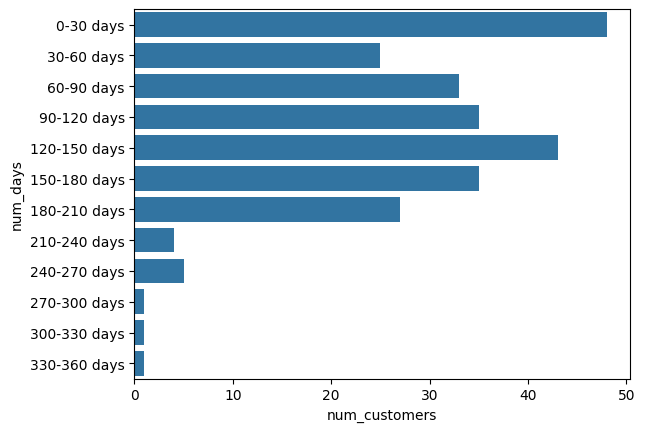

In [116]:
sns.barplot(data=q10_df, y='num_days', x='num_customers', orient='h')

Q11: How many customers downgraded from a pro monthly to a basic monthly plan in 2020?

In [159]:
# Same approach as Q6, but for the window function, order by date
query('''
    WITH ranked_cte AS (
    SELECT 
        customer_id,  
        plan_id,
        LEAD(plan_id) OVER ( 
            PARTITION BY customer_id
            ORDER BY start_date) AS next_plan_id
    FROM subscriptions
    WHERE strftime('%Y', start_date) = '2020'
    )
    
    SELECT 
        COUNT(customer_id) AS downgraded_customers
    FROM ranked_cte
    WHERE plan_id = 2
        AND next_plan_id = 1;
''')

,downgraded_customers
0,0


- No such instance of customers downgrading from pro monthly to basic monthly plan.

**C. Challenge Payment Question**

Q12: The Foodie-Fi team wants you to create a new payments table for the year 2020 that includes amounts paid by each customer in the subscriptions table with the following requirements:

- payments always occur on the same day of month as the original start_date of any paid plan
- once a customer churns they will no longer make payments

In [206]:
q12_df = query('''
    WITH dates_cte AS (
        SELECT 
            customer_id,  
            plan_id,
            plan_name,
            CASE WHEN price IS NULL THEN 0 ELSE price END AS price,
            start_date,
            LEAD(start_date) OVER ( 
                PARTITION BY customer_id
                ORDER BY start_date) AS end_date
        FROM subscriptions INNER JOIN plans
            USING (plan_id)
        WHERE strftime('%Y', start_date) = '2020'
    ),
    dates_revised_cte AS (
        SELECT
            customer_id,
            plan_id,
            plan_name,
            price,
            start_date,
            CASE WHEN end_date IS NULL THEN '2020-12-31' 
                ELSE end_date END AS end_date_adjusted
        FROM
            dates_cte
    ),
    dates_with_payment_periods_cte AS(         
        SELECT
            customer_id,
            plan_id,
            plan_name,
            price,
            start_date,
            end_date_adjusted,
            CASE
                WHEN plan_id IN (0,4) THEN 0
                WHEN plan_id IN (1,2) THEN 
                    CAST(((julianday(end_date_adjusted) - julianday(start_date)) / 30.0) AS INT) + 1
                WHEN plan_id = 3 THEN 1
            END AS payment_periods
        FROM
            dates_revised_cte
    )
    SELECT
        customer_id,
        plan_id,
        plan_name,
        price,
        start_date,
        end_date_adjusted,
        payment_periods,
        (price * payment_periods) AS amount_paid
    FROM
        dates_with_payment_periods_cte
''')
q12_df

,customer_id,plan_id,plan_name,price,start_date,end_date_adjusted,payment_periods,amount_paid
0,1,0,trial,0.0,2020-08-01,2020-08-08,0,0.0
1,1,1,basic monthly,9.9,2020-08-08,2020-12-31,5,49.5
2,2,0,trial,0.0,2020-09-20,2020-09-27,0,0.0
3,2,3,pro annual,199.0,2020-09-27,2020-12-31,1,199.0
4,3,0,trial,0.0,2020-01-13,2020-01-20,0,0.0
...,...,...,...,...,...,...,...,...
2443,999,2,pro monthly,19.9,2020-10-30,2020-12-01,2,39.8
2444,999,4,churn,0.0,2020-12-01,2020-12-31,0,0.0
2445,1000,0,trial,0.0,2020-03-19,2020-03-26,0,0.0
2446,1000,2,pro monthly,19.9,2020-03-26,2020-06-04,3,59.7


Additional statistics:
- Total amount gathered by the company: 105,455.80

In [185]:
q12_df = q12_df[q12_df['price'] != 0]
q12_df.amount_paid.sum()

105455.8

- Total amount gathered by the company, by plan_id

In [191]:
q12_df_grouped = q12_df.groupby('plan_name')['amount_paid'].sum().reset_index()
q12_df_grouped

,plan_name,amount_paid
0,basic monthly,20542.5
1,pro annual,38805.0
2,pro monthly,46108.3


<Axes: xlabel='plan_name', ylabel='amount_paid'>

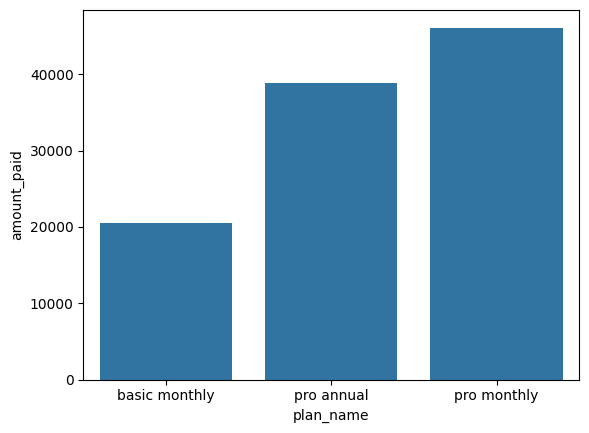

In [192]:
sns.barplot(data=q12_df_grouped, x='plan_name', y='amount_paid')

**D. Additional Questions (Open-Ended)**

Q13: How would you calculate the rate of growth for Foodie-Fi?

- For me, I would compute and track this by: (1) number of active customers by the end of a year - with number of new and retaining customers, and (2) total payments received. The change can be computed annually, for the case of this dataset, from 2020 to 2021.
- Note: To preserve accuracy of those metrics, the stats for all the years involved must be complete. Here, it is assumed that by the time this data is available, the data from 2020 and 2021 are complete.
- Approach: Same query as that in Q2 and Q12, but grouped by year

In [208]:
# Active customers (not churned)
query('''
    WITH customers_2020 AS(
        SELECT COUNT(*) AS num_customers_2020 FROM (
            SELECT DISTINCT customer_id
            FROM subscriptions 
            WHERE strftime('%Y', start_date) = '2020'
            EXCEPT
            SELECT DISTINCT customer_id
            FROM subscriptions
            WHERE strftime('%Y', start_date) = '2020'
            AND plan_id = 4
        )
    ),
    customers_2021 AS(
        SELECT COUNT(*) AS num_customers_2021 FROM (
            SELECT DISTINCT customer_id
            FROM subscriptions
            EXCEPT
            SELECT DISTINCT customer_id
            FROM subscriptions
            WHERE plan_id = 4
        )
    )
    SELECT
        num_customers_2020,
        num_customers_2021,
        ROUND(100 * 
            (num_customers_2021 - num_customers_2020) / CAST(num_customers_2020 AS FLOAT) 
        ,2) || ' %' AS growth_rate 
    FROM
        customers_2020, customers_2021
''')

,num_customers_2020,num_customers_2021,growth_rate
0,764,693,-9.29 %


In [240]:
# Payments comparison
q13_df = query('''
    WITH dates_cte AS (
        SELECT 
            customer_id,  
            plan_id,
            plan_name,
            CASE WHEN price IS NULL THEN 0 ELSE price END AS price,
            start_date,
            LEAD(start_date) OVER ( 
                PARTITION BY customer_id
                ORDER BY start_date) AS end_date
        FROM subscriptions INNER JOIN plans
            USING (plan_id)
        WHERE plan_id != 0 -- Trial plan excluded
    ),
    dates_revised_cte AS (
        SELECT
            customer_id,
            plan_id,
            plan_name,
            price,
            start_date,
            CASE WHEN end_date IS NULL THEN '2021-12-31' 
                ELSE end_date END AS end_date_adjusted
        FROM
            dates_cte
    ),
    dates_with_payment_periods_cte AS(         
        SELECT
            customer_id,
            plan_id,
            plan_name,
            price,
            start_date,
            end_date_adjusted,
            CASE
                WHEN plan_id IN (0,4) THEN 0
                WHEN plan_id IN (1,2) AND strftime('%Y', start_date) = '2020' AND strftime('%Y', end_date_adjusted) = '2020' THEN 
                    CAST(((julianday(end_date_adjusted) - julianday(start_date)) / 30.0) AS INT) + 1
                WHEN plan_id IN (1,2) AND strftime('%Y', start_date) = '2020' AND strftime('%Y', end_date_adjusted) = '2021' THEN 
                    (julianday('2020-12-31') - julianday(start_date)) / 30.0
                WHEN plan_id = 3 AND strftime('%Y', start_date) = '2020' THEN 1
                ELSE 0
            END AS payment_periods_2020,
            CASE
                WHEN plan_id IN (0,4) THEN 0
                WHEN plan_id IN (1,2) AND strftime('%Y', start_date) = '2021' AND strftime('%Y', end_date_adjusted) = '2021' THEN 
                    CAST(((julianday(end_date_adjusted) - julianday(start_date)) / 30.0) AS INT) + 1
                WHEN plan_id IN (1,2) AND strftime('%Y', start_date) = '2020' AND strftime('%Y', end_date_adjusted) = '2021' THEN
                    (julianday(end_date_adjusted) - julianday('2021-01-01')) / 30.0
                WHEN plan_id = 3 AND strftime('%Y', start_date) = '2020' THEN 1
                ELSE 0
            END AS payment_periods_2021

        FROM
            dates_revised_cte
    )
    SELECT
        customer_id,
        plan_id,
        plan_name,
        price,
        start_date,
        end_date_adjusted,
        payment_periods_2020,
        payment_periods_2021,
        (price * payment_periods_2020) AS amount_paid_2020,
        (price * payment_periods_2021) AS amount_paid_2021
    FROM
        dates_with_payment_periods_cte
''')
q13_df.head(30)

,customer_id,plan_id,plan_name,price,start_date,end_date_adjusted,payment_periods_2020,payment_periods_2021,amount_paid_2020,amount_paid_2021
0,1,1,basic monthly,9.9,2020-08-08,2021-12-31,4.833333,12.133333,47.850000,120.120000
1,2,3,pro annual,199.0,2020-09-27,2021-12-31,1.000000,1.000000,199.000000,199.000000
2,3,1,basic monthly,9.9,2020-01-20,2021-12-31,11.533333,12.133333,114.180000,120.120000
3,4,1,basic monthly,9.9,2020-01-24,2020-04-21,3.000000,0.000000,29.700000,0.000000
4,4,4,churn,0.0,2020-04-21,2021-12-31,0.000000,0.000000,0.000000,0.000000
5,5,1,basic monthly,9.9,2020-08-10,2021-12-31,4.766667,12.133333,47.190000,120.120000
6,6,1,basic monthly,9.9,2020-12-30,2021-02-26,0.033333,1.866667,0.330000,18.480000
7,6,4,churn,0.0,2021-02-26,2021-12-31,0.000000,0.000000,0.000000,0.000000
8,7,1,basic monthly,9.9,2020-02-12,2020-05-22,4.000000,0.000000,39.600000,0.000000
9,7,2,pro monthly,19.9,2020-05-22,2021-12-31,7.433333,12.133333,147.923333,241.453333


In [249]:
q13_df_sums = q13_df[['amount_paid_2020','amount_paid_2021']].sum().reset_index().transpose()
q13_df_sums.columns = q13_df_sums.iloc[0]
q13_df_sums = q13_df_sums[1:]
q13_df_sums['2020_2021_change'] = (q13_df_sums['amount_paid_2021'] - q13_df_sums['amount_paid_2020']) / q13_df_sums['amount_paid_2020']
q13_df_sums

index,amount_paid_2020,amount_paid_2021,2020_2021_change
0,100919.67,133363.62,0.321483


In [ ]:
sns.barplot()

Conclusion: There is a 32.15% increase in the company's revenue from 2020 to 2021.

Q14: What key metrics would you recommend Foodie-Fi management to track over time to assess performance of their overall business?

- Churn rate

In [254]:
query('''
    WITH customers_2020 AS(
        SELECT COUNT(DISTINCT customer_id) AS num_customers_2020
        FROM subscriptions 
        WHERE strftime('%Y', start_date) = '2020'
    ),
    churned_2020 AS(
        SELECT COUNT(DISTINCT customer_id) AS num_churned_2020
        FROM subscriptions
        WHERE strftime('%Y', start_date) = '2020'
        AND plan_id = 4
    ),
    customers_2021 AS(
        SELECT COUNT(*) AS num_customers_2021 FROM (
            SELECT DISTINCT customer_id
            FROM subscriptions
            EXCEPT
            SELECT DISTINCT customer_id
            FROM subscriptions
            WHERE strftime('%Y', start_date) = '2020'
            AND plan_id = 4
        )
    ),
    churned_2021 AS(
        SELECT COUNT(DISTINCT customer_id) AS num_churned_2021
        FROM subscriptions
        WHERE strftime('%Y', start_date) = '2021'
        AND plan_id = 4
    ),
    churn_rates AS(
        SELECT
            ROUND(100.0 * num_churned_2020 / num_customers_2020, 2) AS churn_rate_2020,
            ROUND(100.0 * num_churned_2021 / num_customers_2021, 2) AS churn_rate_2021
        FROM
            customers_2020, churned_2020, customers_2021, churned_2021
    )
    SELECT
        churn_rate_2020 || ' %' AS churn_rate_2020,
        churn_rate_2021 || ' %' AS churn_rate_2021,
        ROUND(100 * (churn_rate_2021 - churn_rate_2020) / churn_rate_2020, 2) || ' %' AS change_2020_2021
    FROM
        churn_rates
''')

,churn_rate_2020,churn_rate_2021,change_2020_2021
0,23.6 %,9.29 %,-60.64 %


- The company's churn rate is reduced relatively by 60.64%, from 23.6% of its customers in 2020 to just 9.29% of its customers in 2021.

### Conclusion

With the metrics determined in Q12-Q14:
- Although with a slight decrease in customers from 2020 to 2021, the company grew better by managing to keep its customers (as evidenced by the decrease the churn rate) and an increase in overall revenue (as a result from older customers upgrading from the basic to pro plan).
- Foodie-Fi earned more from pro monthly subscriptions than yearly subscriptions, suggesting that customers want more flexible plans.